# Calcul de la mensualité:

$m$ = mensualité

$N$ = Durée du prêt (en années)

$\alpha$ = Taux d'intéret annuel

$C$ = montant du prêt


Au mois $n$, le restant à payer $C_n$ vaut: $C_n = C_{n-1} + \frac{\alpha}{12}C_{n-1}-m = \left(1+\frac{\alpha}{12}\right)C_{n-1}-m$

On reconnaît une suite arithmético-géométrique de terme général: $C_n = \left(1+\frac{\alpha}{12}\right)^n\left(C-\frac{12m}{\alpha}\right)+\frac{12m}\alpha$

Donc à l'année $N$, le restant à payer (qui doit être nul) vaut: $\left(1+\frac{\alpha}{12}\right)^{12N}\left(C-\frac{12m}{\alpha}\right)+\frac{12m}\alpha$. On obtient:

\begin{align}
m = \frac{\frac{\alpha C}{12}}{1-\left(1+\frac{\alpha}{12}\right)^{-12N}}
\end{align}

In [4]:
def mensualité(alpha, C, N):
    return alpha*C/12/(1-(1+alpha/12)**(-12*N))

def c(n, alpha, C, N):
    m = mensualité(alpha, C, N)
    if n <= 12*N:
        return (1+alpha/12)**n*(C-12*m/alpha)+12*m/alpha
    else:
        return 0

# Calcul du rendement au mois $n$ < $12N$

$\mu$ = croissance annuelle du bien immobilier

$l$ = loyer

$f_n$ = frais de notaire

$f_g$ = frais de gestion locative (en % du loyer)

$A$ = Apport

$p$ = prélèvements sociaux

$i$ = impôts

Au bout du mois $n$, le propriétaire possède:
- Le bien immobilier d'une valeur $(1+\mu)^{\frac{n}{12}}C$
- Le cumul des loyers s'élevant à hauteur de $nl$ (dont il faut déduire les impôts)

Il a dépensé $nm$ en mensualité, $nf_gl$ en frais de gestion locative, $f+A$ en apport total, et est endetté à hauteur de $C_n$

Son rendement au mois $n$ s'élève donc à:

\begin{align}
\eta = \frac{n(l(1-i)-m-f_gl)+\left(1+\mu\right)^\frac{n}{12}C-C_n-(f_n+A)}{f_n+A}
\end{align}

$\textcolor{red}{Quid des impôts sur le revenu}$

In [5]:
def rendement(n, l, alpha, C, N, mu, fn, A, fg, i):
    m = mensualité(alpha, C, N)
    Cn = c(n, alpha, C, N)
    if n <= 12*N: # On généralise la formule après avori remboursé la totalité du prêt
        return((n*(l*(1-i)-m-fg*l)+C*(1+mu)**(n/12)-Cn-(fn+A))/(fn+A))
    else:
        return((n*(l*(1-i)-fg*l)-12*N*m+C*(1+mu)**(n/12)-Cn-(fn+A))/(fn+A))

# Simulation

In [6]:
import numpy as np
import matplotlib.pyplot as plt

289.9798589915459


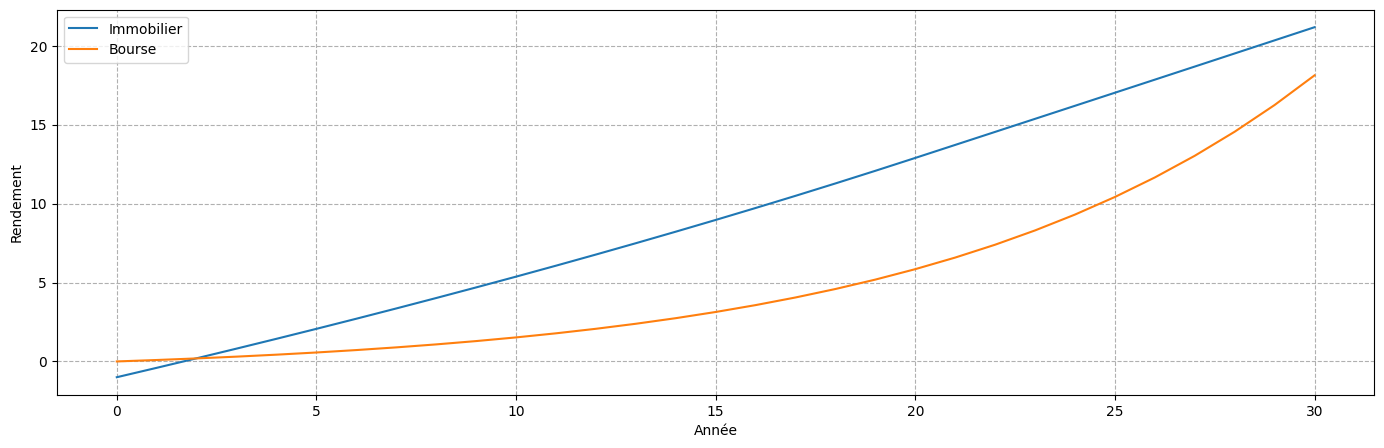

In [7]:
alpha = 3.5/100 # Taux du prêt
N = 20 # Durée totale du prêt
mu = 1/100 # Croissance de la valeur du bien immobilier
C = 50000 # Montant du montant emprunté
l = 630 # Loyer
fn = 8000 # Frais de notaire et d'agence
A = 0 # 10/100*C # Apport
fg = 8/100 # Coûts de gestion locative (en % du loyer)
i = 12.8/100 # impôts sur le revenu

beta = 11/100 # Performance de la bourse
p = 17.2/100 # Prélèvements sociaux

m = mensualité(alpha, C, N) ; print(m)

List_n = range(0, 31)
List_rendement_immo = []
List_rendement_bourse = []

for n in List_n:
    List_rendement_immo.append(rendement(12*n, l, alpha, C, N, mu, fn, A, fg, i))
    List_rendement_bourse.append(((1+beta)**n-1)*(1-p))

plt.figure(figsize=(17, 5))
plt.plot(List_n, List_rendement_immo, label='Immobilier')
plt.plot(List_n, List_rendement_bourse, label='Bourse')
plt.xlabel('Année')
plt.ylabel('Rendement')
plt.grid(linestyle='--')
plt.legend()

In [15]:
import requests
import pandas as pd
from tqdm import tqdm

def get_dvf_data(commune_code, start_date='2020-01-01', end_date='2023-12-31'):
    url = "https://api.cquest.org/dvf?"
    params = {
        'code_commune': commune_code,
        'date_mutation': f'{start_date}:{end_date}',
        'nature_mutation': 'Vente',
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        print(response.json())
        data = response.json()['resultats']
        return data
    else:
        print("Erreur lors de la récupération des données")
        return None

def calculate_price_per_sqm(data):
    if not data:
        return None
    
    records = []
    for item in tqdm(data):
        surface = item.get('surface_relle_bati')
        price = item.get('valeur_fonciere')
        if surface and price:
            price_per_sqm = price / surface
            records.append(price_per_sqm)
    
    if records:
        return np.mean(records)
    else:
        return None

def get_avg_price_per_sqm_by_commune(commune_code):
    dvf_data = get_dvf_data(commune_code)
    avg_price_sqm = calculate_price_per_sqm(dvf_data)
    print(avg_price_sqm)
    if avg_price_sqm:
        return f"Le prix moyen au m² pour la commune {commune_code} est de {avg_price_sqm:.2f} €"
    else:
        return "Pas assez de données pour calculer le prix moyen au m²."

# Exemple d'utilisation
commune_code = "44117"  # Code INSEE de Paris
print(get_avg_price_per_sqm_by_commune(commune_code))

{'source': 'DGFIP / Demande de Valeurs Foncières', 'derniere_maj': '2020-04', 'licence': 'http://data.cquest.org/dgfip_dvf/conditions-generales-dutilisation.pdf', 'nb_resultats': 1216, 'resultats': [{'code_service_ch': None, 'reference_document': None, 'articles_1': None, 'articles_2': None, 'articles_3': None, 'articles_4': None, 'articles_5': None, 'numero_disposition': '000001', 'date_mutation': '2019-02-15', 'nature_mutation': 'Vente', 'valeur_fonciere': 1241.2, 'numero_voie': None, 'suffixe_numero': None, 'type_voie': None, 'code_voie': 'B270', 'voie': 'LA RENEE', 'code_postal': '44330', 'commune': 'PALLET (LE)', 'code_departement': '44', 'code_commune': '44117', 'prefixe_section': None, 'section': 'AB', 'numero_plan': '44117000AB0113', 'numero_volume': None, 'lot_1': None, 'surface_lot_1': None, 'lot_2': None, 'surface_lot_2': None, 'lot_3': None, 'surface_lot_3': None, 'lot_4': None, 'surface_lot_4': None, 'lot_5': None, 'surface_lot_51': None, 'nombre_lots': '0', 'code_type_loc

100%|██████████| 1216/1216 [00:00<00:00, 609060.62it/s]

2157.59950459909
Le prix moyen au m² pour la commune 44117 est de 2157.60 €
